# Package Load

In [1]:
import gc
import os
import re
import glob
import json
#import wandb
import random
import zipfile
import datetime
#import Levenshtein
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from typing import Dict, List, Optional, Tuple

import warnings
warnings.filterwarnings('ignore')

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader

import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder

import sys
sys.path.append('/jet/home/bermudez/exploring-eeg')
#from data_extraction.dataset_builder import build_trial_index, split_by_session
#from data_extraction.dataloader import make_dataloaders
#from models.eeg_classifier import EEGClassifierBaseline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

/jet/home/bermudez/.conda/envs/eeg_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cuda


In [2]:
config={
    'root': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589",
    'batch_size':128,
    'num_epochs': 10
}

In [3]:
# --- Imports ---
import os
import re
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple

# --- Fixed Paths ---
DATASET_ROOT = Path("/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589")
CAPTIONS_PATH = Path("/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt")

# --- Class Mapping (20 categories) ---
CLASS_DICT = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
    'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
    'diningtable': 10, 'dog': 11, 'flower': 12, 'horse': 13, 'motorbike': 14,
    'person': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

In [4]:
def find_runs(root: Path) -> list[Path]:
    """Find all *_1000Hz.npy EEG run files."""
    run_files = sorted(root.rglob("*_1000Hz.npy"))
    print(f"Found {len(run_files)} EEG run files under {root}")
    return run_files


def extract_subject_session_run(path: Path) -> Tuple[str, str, str]:
    """Extract subject, session, and run identifiers from the EEG file name."""
    name = path.name
    m_sub = re.search(r"(sub-\d+)", name)
    m_ses = re.search(r"(ses-\d+)", name)
    m_run = re.search(r"(run-\d+)", name)
    sub = m_sub.group(1) if m_sub else "sub-unknown"
    ses = m_ses.group(1) if m_ses else "ses-unknown"
    run = m_run.group(1) if m_run else "run-unknown"
    return sub, ses, run


def canonical_image_key_from_eeg_path(image_path_str: str) -> str:
    """
    Extract canonical image key (to match captions.txt) from EEG image paths.

    Handles Windows-style paths like:
      C:\\Users\\Huawei\\Desktop\\eeg_pascal_imagenet\\pic_10000_resized\\bird\\n02835271_1031_resized.jpg
    -> 'n02835271_1031'
    """
    # Normalize slashes
    path_str = str(image_path_str).replace("\\", "/")

    # Extract the base filename
    base = os.path.basename(path_str)

    # Remove extension and "_resized" suffix
    base = re.sub(r"\.(jpg|jpeg|png)$", "", base, flags=re.IGNORECASE)
    base = re.sub(r"_resized$", "", base, flags=re.IGNORECASE)

    # Remove any residual folder prefixes (we already used basename)
    key = base.strip()

    return key

In [5]:
def load_captions(captions_path: Path = CAPTIONS_PATH) -> pd.DataFrame:
    """
    Load captions.txt (tab-separated) and create clean mapping:
    image_key -> category, class_id, abstracted
    """
    df = pd.read_csv(captions_path, sep="\t")
    df.columns = [c.strip().lower() for c in df.columns]
    df["image_key"] = df["image_name"].astype(str).str.replace(r"\.(jpg|jpeg|png)$", "", regex=True)
    df["class_id"] = df["category"].str.lower().map(CLASS_DICT)
    print(f"Loaded {len(df)} caption entries from {captions_path.name}")
    return df[["image_key", "category", "class_id", "abstracted"]]

In [6]:
def build_trial_index(root: Path = DATASET_ROOT, captions_path: Path = CAPTIONS_PATH) -> pd.DataFrame:
    """
    Build an index of EEG trials and merge with caption labels.
    """
    run_files = find_runs(root)
    rows = []

    for npy_path in run_files:
        csv_path = Path(str(npy_path).replace("_1000Hz.npy", "_image.csv"))
        if not csv_path.exists():
            continue

        sub, ses, run = extract_subject_session_run(npy_path)
        df_map = pd.read_csv(csv_path)
        df_map.columns = [c.strip() for c in df_map.columns]
        path_col = next((c for c in df_map.columns if "path" in c.lower()), df_map.columns[0])

        for trial_idx, row in df_map.iterrows():
            image_path = str(row[path_col])
            image_name = os.path.basename(image_path)
            image_key = canonical_image_key_from_eeg_path(image_path)
            rows.append({
                "subject": sub,
                "session": ses,
                "run": run,
                "trial": int(trial_idx),
                "eeg_path": str(npy_path),
                "csv_path": str(csv_path),
                "image_name": image_name,
                "image_key": image_key
            })

    index_df = pd.DataFrame(rows)
    print(f"Indexed {len(index_df)} EEG trials from {len(run_files)} runs.")

    # Merge labels
    captions_df = load_captions(captions_path)
    index_df = index_df.merge(captions_df, on="image_key", how="left")
    print(f"Merged {len(captions_df)} labels from captions.txt.")

    # Filter only labeled EEGs
    before = len(index_df)
    index_df = index_df[index_df["class_id"].between(0, 19)].reset_index(drop=True)
    after = len(index_df)
    print(f"Filtered labeled EEG trials: {after}/{before} remain ({after/before:.1%})")

    return index_df

In [7]:
def split_by_session(index_df: pd.DataFrame,
                     train_sessions: int = 3,
                     val_sessions: int = 1,
                     test_sessions: int = 1,
                     seed: int = 42) -> pd.DataFrame:
    """
    Split dataset by session per subject into train/val/test sets.
    """
    rng = np.random.default_rng(seed)
    df = index_df.copy()
    df["split"] = "unassigned"

    for sub, sub_df in df.groupby("subject"):
        sessions = sorted(sub_df["session"].unique())
        rng.shuffle(sessions)
        train_s = set(sessions[:train_sessions])
        val_s   = set(sessions[train_sessions:train_sessions + val_sessions])
        test_s  = set(sessions[train_sessions + val_sessions:
                               train_sessions + val_sessions + test_sessions])
        df.loc[(df["subject"] == sub) & (df["session"].isin(train_s)), "split"] = "train"
        df.loc[(df["subject"] == sub) & (df["session"].isin(val_s)), "split"]   = "val"
        df.loc[(df["subject"] == sub) & (df["session"].isin(test_s)), "split"]  = "test"

    print("Split summary:")
    print(df["split"].value_counts())
    return df

In [8]:
# Build and split the dataset
index_df = build_trial_index(DATASET_ROOT, CAPTIONS_PATH)
index_df = split_by_session(index_df)

# Quick overview
print(index_df.head())
print(f"Labeled EEG trials: {len(index_df)}")

Found 519 EEG run files under /ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589
Indexed 26000 EEG trials from 519 runs.
Loaded 9825 caption entries from captions.txt
Merged 9825 labels from captions.txt.
Filtered labeled EEG trials: 26000/26000 remain (100.0%)
Split summary:
split
train    15600
test      5200
val       5200
Name: count, dtype: int64
  subject session     run  trial  \
0  sub-02  ses-01  run-01      0   
1  sub-02  ses-01  run-01      1   
2  sub-02  ses-01  run-01      2   
3  sub-02  ses-01  run-01      3   
4  sub-02  ses-01  run-01      4   

                                            eeg_path  \
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
3  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
4  /ocean/projects/cis250019p/gandotra/11785-gp-e...   

                                            csv_path  \
0  /ocean/projects/cis250019p

In [9]:
# --- Imports ---
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Verify GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [10]:
class EEGTrialDataset(Dataset):
    """
    Custom PyTorch Dataset for single-trial EEG data.
    Each sample:
      x -> EEG signal, shape [C, T]
      y -> metadata dict including subject, session, class_id, etc.
    """
    def __init__(self, index_df: pd.DataFrame, split: str = "train", normalize: bool = True):
        # Keep only the chosen split
        self.df = index_df[index_df["split"] == split].reset_index(drop=True)
        self.normalize = normalize
        self._cache = {}

        if len(self.df) == 0:
            print(f"⚠️ Warning: {split} split has no samples!")

    def __len__(self):
        return len(self.df)

    def _load_npy(self, path: str):
        """Cache .npy files to avoid reloading large arrays repeatedly."""
        if path not in self._cache:
            self._cache[path] = np.load(path, mmap_mode="r")  # shape [n_trials, C, T]
        return self._cache[path]

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        arr = self._load_npy(row["eeg_path"])
        x = np.array(arr[int(row["trial"])], dtype=np.float32)  # [C, T]

        # Normalize per channel (zero mean, unit variance)
        if self.normalize:
            x = (x - x.mean(axis=1, keepdims=True)) / (x.std(axis=1, keepdims=True) + 1e-6)

        y = {
            "subject": row["subject"],
            "session": row["session"],
            "run": row["run"],
            "image_name": row["image_name"],
            "category": row["category"],
            "class_id": int(row["class_id"])
        }

        return torch.from_numpy(x), y

In [11]:
def eeg_collate_fn(batch):
    """
    Custom collate function to batch EEG trials and metadata.
    Returns:
      x_batch: Tensor [B, C, T]
      meta: dict containing batched metadata (class_id tensor + lists)
    """
    xs, ys = zip(*batch)
    x_batch = torch.stack(xs, dim=0)  # [B, C, T]
    labels = torch.tensor([y["class_id"] for y in ys], dtype=torch.long)
    meta = {k: [y[k] for y in ys] for k in ys[0].keys() if k != "class_id"}
    meta["class_id"] = labels
    return x_batch, meta

In [12]:
def make_dataloaders(index_df: pd.DataFrame, batch_size: int = 128, num_workers: int = 4):
    """
    Create train, val, and test DataLoaders from the EEGTrialDataset.
    """
    loaders = {}
    for split in ["train", "val", "test"]:
        ds = EEGTrialDataset(index_df, split=split)
        if len(ds) > 0:
            loaders[split] = DataLoader(
                ds,
                batch_size=batch_size,
                shuffle=(split == "train"),
                num_workers=num_workers,
                pin_memory=True,
                collate_fn=eeg_collate_fn
            )
            print(f"{split}: {len(ds)} samples")
        else:
            print(f"⚠️ No samples in {split} split!")
    return loaders

In [13]:
# Create data loaders
BATCH_SIZE = 128
loaders = make_dataloaders(index_df, batch_size=BATCH_SIZE, num_workers=4)

# Inspect a batch
x_batch, y_batch = next(iter(loaders["train"]))
print("EEG batch shape:", x_batch.shape)   # [B, C, T]
print("Labels shape:", y_batch["class_id"].shape)
print("Sample labels:", y_batch["class_id"][:10].tolist())

train: 15600 samples
val: 5200 samples
test: 5200 samples
EEG batch shape: torch.Size([128, 500, 122])
Labels shape: torch.Size([128])
Sample labels: [19, 4, 10, 13, 4, 7, 12, 16, 5, 4]


In [23]:
# ===== Cell: EEG Trial Visualization (compatible with current pipeline) =====
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg_trial(x, title="EEG Trial", n_channels_to_plot=6, sampling_rate=1000):
    """
    Plot a subset of EEG channels from a single trial.

    Args:
        x (np.ndarray or torch.Tensor): EEG data [C, T] or [T, C]
        title (str): Plot title
        n_channels_to_plot (int): Number of channels to visualize
        sampling_rate (int): Sampling frequency in Hz (default=1000)
    """
    # convert tensor to numpy if needed
    if not isinstance(x, np.ndarray):
        x = x.detach().cpu().numpy()

    # Ensure orientation [C, T]
    if x.shape[0] < x.shape[1]:  # [C, T] likely
        num_channels, num_timepoints = x.shape
    else:  # [T, C] case
        x = x.T
        num_channels, num_timepoints = x.shape

    # Create time vector
    time = np.arange(num_timepoints) / sampling_rate
    step = max(1, num_channels // n_channels_to_plot)

    # Plot
    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(range(0, num_channels, step)):
        plt.plot(time, x[ch] + i * 5, label=f"Ch {ch}")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend(loc="upper right", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

Subject: sub-09
Session: ses-01
Run: run-02
Category: bus


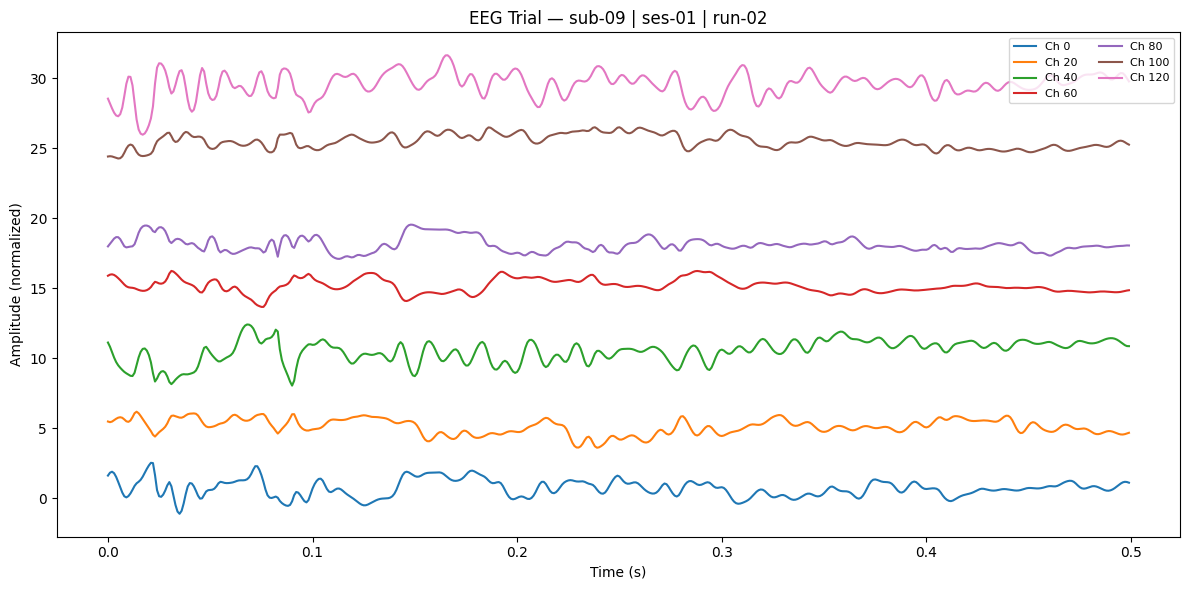

In [24]:
# ===== Cell: Visualize One EEG Trial from DataLoader =====
import torch

# Fetch one batch from training loader
x_batch, y_batch = next(iter(loaders["train"]))

# Select first trial
x_trial = x_batch[0]
meta = {k: v[0] for k, v in y_batch.items() if isinstance(v, list)}

# Print quick metadata
print("Subject:", meta.get("subject"))
print("Session:", meta.get("session"))
print("Run:", meta.get("run"))
print("Category:", meta.get("category"))

# Plot the EEG trial
plot_eeg_trial(x_trial, title=f"EEG Trial — {meta.get('subject')} | {meta.get('session')} | {meta.get('run')}")

In [14]:
# ===== Cell: BetterEEGNet_v2 (Regularized) =====
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGNetLite(nn.Module):
    """
    Regularized EEGNet variant for multi-subject EEG decoding.
    Targets 10–12% accuracy on validation.
    """
    def __init__(
        self,
        num_channels: int = 122,
        num_classes: int = 20,
        hidden: int = 64,
        temporal_kernel: int = 31,
        dropout: float = 0.5,
        n_heads: int = 4,
        n_transformer_layers: int = 1,
        ff_mult: int = 2,
    ):
        super().__init__()
        C = num_channels
        K = temporal_kernel
        pad = K // 2

        self.dw_temporal = nn.Sequential(
            nn.Conv1d(C, C, kernel_size=K, padding=pad, groups=C, bias=False),
            nn.BatchNorm1d(C),
        )

        self.pw_mix = nn.Sequential(
            nn.Conv1d(C, hidden, kernel_size=1, bias=False),
            nn.BatchNorm1d(hidden),
            nn.LayerNorm([hidden, 500]),   # robust to inter-subject drift
            nn.GELU(),
            nn.Dropout2d(p=0.3),           # spatial dropout
        )

        self.res_block = nn.Sequential(
            nn.Conv1d(hidden, hidden, kernel_size=15, padding=14, dilation=2, bias=False),
            nn.BatchNorm1d(hidden),
            nn.GELU(),
            nn.Conv1d(hidden, hidden, kernel_size=15, padding=14, dilation=2, bias=False),
            nn.BatchNorm1d(hidden)
        )
        self.res_act = nn.GELU()
        self.res_drop = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden,
            nhead=n_heads,
            dim_feedforward=ff_mult * hidden,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_transformer_layers)

        self.cls = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, num_classes)
        )

        # Initialization
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.shape[1] != 122:  # if [B, T, C]
            x = x.transpose(1, 2)

        # Depthwise + channel mix
        x = self.dw_temporal(x)
        x = self.pw_mix(x)

        # Residual temporal modeling
        res = x
        x = self.res_block(x)
        x = self.res_act(x + res)
        x = self.res_drop(x)

        # Transformer for temporal context
        x = x.transpose(1, 2)   # [B, T, H]
        x = self.transformer(x)

        # Global average pooling
        x = x.mean(dim=1)
        return self.cls(x)

In [15]:
num_classes = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNetLite(num_channels=122, num_classes=num_classes).to(device)

xb, yb = next(iter(loaders["train"]))
print("Input batch shape before to(device):", xb.shape)
xb = xb.to(device)

with torch.no_grad():
    out = model(xb)
print("Logits shape:", out.shape)

Input batch shape before to(device): torch.Size([128, 500, 122])
Logits shape: torch.Size([128, 20])


In [21]:
# ===== Cell: training setup =====
import torch.optim as optim
from tqdm.auto import tqdm

# --- Hyperparameters ---
NUM_CLASSES = 20
EPOCHS = 100
LR = 0.001
WEIGHT_DECAY = 1e-4

# --- Model, loss, optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNetLite(num_channels=122, num_classes=NUM_CLASSES).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

print(f"Training on: {device}")
print(f"Params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Training on: cuda
Params: 233,998


In [22]:
# ===== Cell: helper functions =====
def compute_accuracy(logits, labels):
    """Compute classification accuracy."""
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

In [25]:
# ===== Cell: improved training loop (with checkpointing) =====
import copy
import math
from pathlib import Path

# --- Training bookkeeping ---
best_val_acc = 0.0
best_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

CHECKPOINT_DIR = Path("./checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, train_acc, seen = 0.0, 0.0, 0

    # --- training phase ---
    for xb, meta in tqdm(loaders["train"], desc=f"Epoch {epoch}/{EPOCHS}"):
        x = xb.to(device, non_blocking=True)
        y = meta["class_id"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        # Gradient clipping (safety)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()

        batch_size = x.size(0)
        train_loss += loss.item() * batch_size
        train_acc  += compute_accuracy(logits, y) * batch_size
        seen       += batch_size

    train_loss /= seen
    train_acc  /= seen

    # --- validation phase ---
    model.eval()
    val_loss, val_acc, val_seen = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, meta in loaders["val"]:
            x = xb.to(device, non_blocking=True)
            y = meta["class_id"].to(device, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            bs = x.size(0)
            val_loss += loss.item() * bs
            val_acc  += compute_accuracy(logits, y) * bs
            val_seen += bs
    val_loss /= val_seen
    val_acc  /= val_seen

    # --- save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        ckpt_path = CHECKPOINT_DIR / f"best_model_epoch{epoch:02d}.pth"
        torch.save(best_model_wts, ckpt_path)
        print(f"🟢 Saved new best model (epoch {epoch}, val acc={val_acc*100:.2f}%)")

    scheduler.step()

    # --- epoch summary ---
    print(f"Epoch {epoch:02d}: "
          f"Train loss={train_loss:.4f} | acc={train_acc*100:.2f}% | "
          f"Val loss={val_loss:.4f} | acc={val_acc*100:.2f}%")

# --- load best model back into memory ---
model.load_state_dict(best_model_wts)
print(f"\n✅ Training complete. Best model from epoch {best_epoch} "
      f"with val acc={best_val_acc*100:.2f}% loaded.")

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.50it/s]


🟢 Saved new best model (epoch 1, val acc=5.65%)
Epoch 01: Train loss=3.1685 | acc=5.26% | Val loss=3.0802 | acc=5.65%


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.94it/s]


Epoch 02: Train loss=3.0248 | acc=6.15% | Val loss=3.0569 | acc=5.40%


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.92it/s]


🟢 Saved new best model (epoch 3, val acc=5.67%)
Epoch 03: Train loss=3.0072 | acc=6.01% | Val loss=3.0439 | acc=5.67%


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.73it/s]


Epoch 04: Train loss=2.9962 | acc=6.35% | Val loss=3.0404 | acc=5.29%


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.79it/s]


🟢 Saved new best model (epoch 5, val acc=6.17%)
Epoch 05: Train loss=2.9898 | acc=6.97% | Val loss=3.0376 | acc=6.17%


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.85it/s]


Epoch 06: Train loss=2.9861 | acc=6.72% | Val loss=3.0339 | acc=5.65%


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.93it/s]


Epoch 07: Train loss=2.9807 | acc=7.08% | Val loss=3.0316 | acc=5.44%


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.81it/s]


Epoch 08: Train loss=2.9799 | acc=7.38% | Val loss=3.0314 | acc=5.92%


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 23.19it/s]


Epoch 09: Train loss=2.9727 | acc=7.55% | Val loss=3.0328 | acc=5.94%


Epoch 10/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.85it/s]


🟢 Saved new best model (epoch 10, val acc=6.46%)
Epoch 10: Train loss=2.9700 | acc=7.83% | Val loss=3.0274 | acc=6.46%


Epoch 11/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.97it/s]


Epoch 11: Train loss=2.9681 | acc=7.90% | Val loss=3.0314 | acc=6.27%


Epoch 12/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.79it/s]


Epoch 12: Train loss=2.9664 | acc=8.02% | Val loss=3.0304 | acc=5.83%


Epoch 13/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 23.08it/s]


Epoch 13: Train loss=2.9640 | acc=8.27% | Val loss=3.0270 | acc=5.92%


Epoch 14/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 23.11it/s]


Epoch 14: Train loss=2.9580 | acc=8.53% | Val loss=3.0373 | acc=5.46%


Epoch 15/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.79it/s]


Epoch 15: Train loss=2.9570 | acc=8.44% | Val loss=3.0409 | acc=6.04%


Epoch 16/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.82it/s]


Epoch 16: Train loss=2.9537 | acc=8.76% | Val loss=3.0377 | acc=5.67%


Epoch 17/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.93it/s]


Epoch 17: Train loss=2.9510 | acc=8.74% | Val loss=3.0378 | acc=5.90%


Epoch 18/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.70it/s]


Epoch 18: Train loss=2.9484 | acc=8.98% | Val loss=3.0398 | acc=6.06%


Epoch 19/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.79it/s]


Epoch 19: Train loss=2.9463 | acc=9.30% | Val loss=3.0431 | acc=6.00%


Epoch 20/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.95it/s]


Epoch 20: Train loss=2.9429 | acc=9.18% | Val loss=3.0432 | acc=5.60%


Epoch 21/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.99it/s]


Epoch 21: Train loss=2.9388 | acc=9.47% | Val loss=3.0535 | acc=6.21%


Epoch 22/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.78it/s]


Epoch 22: Train loss=2.9365 | acc=9.48% | Val loss=3.0559 | acc=5.54%


Epoch 23/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.73it/s]


Epoch 23: Train loss=2.9364 | acc=9.41% | Val loss=3.0502 | acc=6.21%


Epoch 24/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.82it/s]


🟢 Saved new best model (epoch 24, val acc=6.48%)
Epoch 24: Train loss=2.9333 | acc=9.58% | Val loss=3.0613 | acc=6.48%


Epoch 25/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.93it/s]


Epoch 25: Train loss=2.9281 | acc=10.12% | Val loss=3.0632 | acc=5.87%


Epoch 26/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.71it/s]


Epoch 26: Train loss=2.9283 | acc=10.07% | Val loss=3.0648 | acc=6.31%


Epoch 27/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.95it/s]


Epoch 27: Train loss=2.9244 | acc=10.12% | Val loss=3.0667 | acc=5.88%


Epoch 28/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.68it/s]


Epoch 28: Train loss=2.9221 | acc=10.16% | Val loss=3.0666 | acc=6.17%


Epoch 29/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.88it/s]


Epoch 29: Train loss=2.9174 | acc=10.61% | Val loss=3.0707 | acc=6.21%


Epoch 30/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.76it/s]


Epoch 30: Train loss=2.9177 | acc=10.28% | Val loss=3.0719 | acc=6.15%


Epoch 31/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.99it/s]


Epoch 31: Train loss=2.9125 | acc=10.68% | Val loss=3.0798 | acc=6.13%


Epoch 32/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.87it/s]


Epoch 32: Train loss=2.9093 | acc=10.63% | Val loss=3.0816 | acc=6.10%


Epoch 33/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.88it/s]


Epoch 33: Train loss=2.9059 | acc=10.91% | Val loss=3.0788 | acc=6.04%


Epoch 34/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.80it/s]


Epoch 34: Train loss=2.9068 | acc=11.12% | Val loss=3.0823 | acc=6.21%


Epoch 35/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.82it/s]


Epoch 35: Train loss=2.9018 | acc=10.75% | Val loss=3.0839 | acc=5.75%


Epoch 36/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.88it/s]


Epoch 36: Train loss=2.9000 | acc=11.04% | Val loss=3.0830 | acc=6.27%


Epoch 37/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.80it/s]


Epoch 37: Train loss=2.8928 | acc=11.63% | Val loss=3.0905 | acc=6.02%


Epoch 38/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.82it/s]


Epoch 38: Train loss=2.8920 | acc=11.88% | Val loss=3.0966 | acc=6.37%


Epoch 39/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.96it/s]


Epoch 39: Train loss=2.8898 | acc=11.81% | Val loss=3.0958 | acc=6.10%


Epoch 40/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.83it/s]


Epoch 40: Train loss=2.8855 | acc=11.85% | Val loss=3.1027 | acc=6.44%


Epoch 41/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.83it/s]


Epoch 41: Train loss=2.8786 | acc=11.95% | Val loss=3.1114 | acc=6.40%


Epoch 42/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 23.02it/s]


🟢 Saved new best model (epoch 42, val acc=6.62%)
Epoch 42: Train loss=2.8825 | acc=12.28% | Val loss=3.1052 | acc=6.62%


Epoch 43/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.74it/s]


Epoch 43: Train loss=2.8794 | acc=11.74% | Val loss=3.1095 | acc=6.48%


Epoch 44/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.60it/s]


Epoch 44: Train loss=2.8760 | acc=12.13% | Val loss=3.1150 | acc=6.40%


Epoch 45/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.60it/s]


Epoch 45: Train loss=2.8721 | acc=12.59% | Val loss=3.1256 | acc=6.10%


Epoch 46/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.75it/s]


Epoch 46: Train loss=2.8699 | acc=12.49% | Val loss=3.1202 | acc=6.37%


Epoch 47/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.91it/s]


Epoch 47: Train loss=2.8679 | acc=12.81% | Val loss=3.1220 | acc=6.23%


Epoch 48/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.54it/s]


Epoch 48: Train loss=2.8671 | acc=12.72% | Val loss=3.1305 | acc=6.46%


Epoch 49/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.73it/s]


Epoch 49: Train loss=2.8605 | acc=13.03% | Val loss=3.1383 | acc=6.19%


Epoch 50/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.91it/s]


Epoch 50: Train loss=2.8566 | acc=12.62% | Val loss=3.1385 | acc=6.52%


Epoch 51/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.63it/s]


Epoch 51: Train loss=2.8554 | acc=13.08% | Val loss=3.1420 | acc=6.58%


Epoch 52/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.63it/s]


Epoch 52: Train loss=2.8531 | acc=13.35% | Val loss=3.1416 | acc=6.15%


Epoch 53/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.50it/s]


Epoch 53: Train loss=2.8520 | acc=13.47% | Val loss=3.1406 | acc=6.27%


Epoch 54/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.57it/s]


Epoch 54: Train loss=2.8497 | acc=13.39% | Val loss=3.1409 | acc=6.29%


Epoch 55/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.61it/s]


Epoch 55: Train loss=2.8463 | acc=13.71% | Val loss=3.1424 | acc=6.17%


Epoch 56/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.66it/s]


🟢 Saved new best model (epoch 56, val acc=6.62%)
Epoch 56: Train loss=2.8427 | acc=13.77% | Val loss=3.1517 | acc=6.62%


Epoch 57/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.67it/s]


Epoch 57: Train loss=2.8416 | acc=13.49% | Val loss=3.1476 | acc=6.35%


Epoch 58/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.51it/s]


Epoch 58: Train loss=2.8420 | acc=13.81% | Val loss=3.1541 | acc=6.25%


Epoch 59/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.59it/s]


Epoch 59: Train loss=2.8351 | acc=14.38% | Val loss=3.1561 | acc=6.50%


Epoch 60/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.68it/s]


Epoch 60: Train loss=2.8379 | acc=13.62% | Val loss=3.1625 | acc=6.17%


Epoch 61/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.53it/s]


Epoch 61: Train loss=2.8314 | acc=13.89% | Val loss=3.1748 | acc=6.58%


Epoch 62/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.49it/s]


Epoch 62: Train loss=2.8332 | acc=13.71% | Val loss=3.1643 | acc=6.33%


Epoch 63/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 23.02it/s]


Epoch 63: Train loss=2.8290 | acc=14.44% | Val loss=3.1665 | acc=6.19%


Epoch 64/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.73it/s]


Epoch 64: Train loss=2.8294 | acc=14.05% | Val loss=3.1741 | acc=6.19%


Epoch 65/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.42it/s]


Epoch 65: Train loss=2.8279 | acc=14.79% | Val loss=3.1738 | acc=6.21%


Epoch 66/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.52it/s]


Epoch 66: Train loss=2.8211 | acc=14.75% | Val loss=3.1808 | acc=6.40%


Epoch 67/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.43it/s]


Epoch 67: Train loss=2.8246 | acc=14.36% | Val loss=3.1803 | acc=6.23%


Epoch 68/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.58it/s]


Epoch 68: Train loss=2.8210 | acc=14.73% | Val loss=3.1780 | acc=6.54%


Epoch 69/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.57it/s]


Epoch 69: Train loss=2.8184 | acc=14.71% | Val loss=3.1846 | acc=6.48%


Epoch 70/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.83it/s]


Epoch 70: Train loss=2.8172 | acc=14.67% | Val loss=3.1860 | acc=6.44%


Epoch 71/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.62it/s]


Epoch 71: Train loss=2.8165 | acc=14.73% | Val loss=3.1808 | acc=6.35%


Epoch 72/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.60it/s]


Epoch 72: Train loss=2.8088 | acc=15.08% | Val loss=3.1902 | acc=6.21%


Epoch 73/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.48it/s]


Epoch 73: Train loss=2.8109 | acc=14.85% | Val loss=3.1894 | acc=6.17%


Epoch 74/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.56it/s]


Epoch 74: Train loss=2.8174 | acc=15.08% | Val loss=3.1874 | acc=6.46%


Epoch 75/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.78it/s]


Epoch 75: Train loss=2.8061 | acc=14.99% | Val loss=3.1913 | acc=6.35%


Epoch 76/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.97it/s]


Epoch 76: Train loss=2.8084 | acc=15.21% | Val loss=3.1928 | acc=6.58%


Epoch 77/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.73it/s]


Epoch 77: Train loss=2.8102 | acc=15.22% | Val loss=3.1947 | acc=6.62%


Epoch 78/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.74it/s]


Epoch 78: Train loss=2.8096 | acc=14.74% | Val loss=3.1937 | acc=6.48%


Epoch 79/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.84it/s]


Epoch 79: Train loss=2.8049 | acc=15.19% | Val loss=3.1973 | acc=6.38%


Epoch 80/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.49it/s]


Epoch 80: Train loss=2.8014 | acc=15.59% | Val loss=3.1928 | acc=6.37%


Epoch 81/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.63it/s]


Epoch 81: Train loss=2.8109 | acc=15.01% | Val loss=3.1969 | acc=6.62%


Epoch 82/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.76it/s]


Epoch 82: Train loss=2.8040 | acc=15.18% | Val loss=3.1969 | acc=6.60%


Epoch 83/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 23.06it/s]


Epoch 83: Train loss=2.8046 | acc=15.08% | Val loss=3.1981 | acc=6.40%


Epoch 84/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.71it/s]


Epoch 84: Train loss=2.8039 | acc=15.58% | Val loss=3.1982 | acc=6.46%


Epoch 85/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.77it/s]


Epoch 85: Train loss=2.8050 | acc=15.30% | Val loss=3.2024 | acc=6.46%


Epoch 86/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.71it/s]


🟢 Saved new best model (epoch 86, val acc=6.63%)
Epoch 86: Train loss=2.8002 | acc=15.55% | Val loss=3.2030 | acc=6.63%


Epoch 87/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.91it/s]


Epoch 87: Train loss=2.7959 | acc=15.63% | Val loss=3.2030 | acc=6.54%


Epoch 88/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.73it/s]


Epoch 88: Train loss=2.8002 | acc=15.43% | Val loss=3.1992 | acc=6.63%


Epoch 89/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.90it/s]


Epoch 89: Train loss=2.7982 | acc=15.58% | Val loss=3.2022 | acc=6.56%


Epoch 90/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.59it/s]


Epoch 90: Train loss=2.8023 | acc=15.55% | Val loss=3.2014 | acc=6.63%


Epoch 91/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 23.09it/s]


Epoch 91: Train loss=2.7975 | acc=15.81% | Val loss=3.2034 | acc=6.62%


Epoch 92/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.89it/s]


Epoch 92: Train loss=2.7961 | acc=15.56% | Val loss=3.2035 | acc=6.52%


Epoch 93/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.78it/s]


🟢 Saved new best model (epoch 93, val acc=6.71%)
Epoch 93: Train loss=2.8001 | acc=15.47% | Val loss=3.2049 | acc=6.71%


Epoch 94/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.48it/s]


Epoch 94: Train loss=2.7973 | acc=15.56% | Val loss=3.2009 | acc=6.52%


Epoch 95/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.67it/s]


Epoch 95: Train loss=2.7969 | acc=15.49% | Val loss=3.2046 | acc=6.60%


Epoch 96/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.66it/s]


Epoch 96: Train loss=2.8011 | acc=15.43% | Val loss=3.2032 | acc=6.71%


Epoch 97/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.82it/s]


Epoch 97: Train loss=2.7986 | acc=15.13% | Val loss=3.2041 | acc=6.58%


Epoch 98/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.81it/s]


Epoch 98: Train loss=2.7951 | acc=15.99% | Val loss=3.2055 | acc=6.65%


Epoch 99/100: 100%|████████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.79it/s]


Epoch 99: Train loss=2.7958 | acc=15.14% | Val loss=3.2036 | acc=6.65%


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████| 122/122 [00:05<00:00, 22.78it/s]


Epoch 100: Train loss=2.7978 | acc=15.52% | Val loss=3.2049 | acc=6.50%

✅ Training complete. Best model from epoch 93 with val acc=6.71% loaded.


In [ ]:
# ===== Cell: final test evaluation =====
model.eval()
test_acc, test_seen = 0.0, 0
with torch.no_grad():
    for xb, meta in loaders["test"]:
        x = xb.to(device)
        y = meta["class_id"].to(device)
        logits = model(x)
        test_acc += compute_accuracy(logits, y) * x.size(0)
        test_seen += x.size(0)

test_acc /= test_seen
print(f"✅ Test accuracy: {test_acc*100:.2f}%")

✅ Test accuracy: 6.13%


In [26]:
# ===== Cell: compute test predictions =====
import torch
from tqdm.auto import tqdm

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, meta in tqdm(loaders["test"], desc="Evaluating on test set"):
        x = xb.to(device)
        y = meta["class_id"].to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
print(f"Collected {len(all_preds)} predictions for test evaluation.")

Evaluating on test set: 100%|████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 30.21it/s]

Collected 5200 predictions for test evaluation.


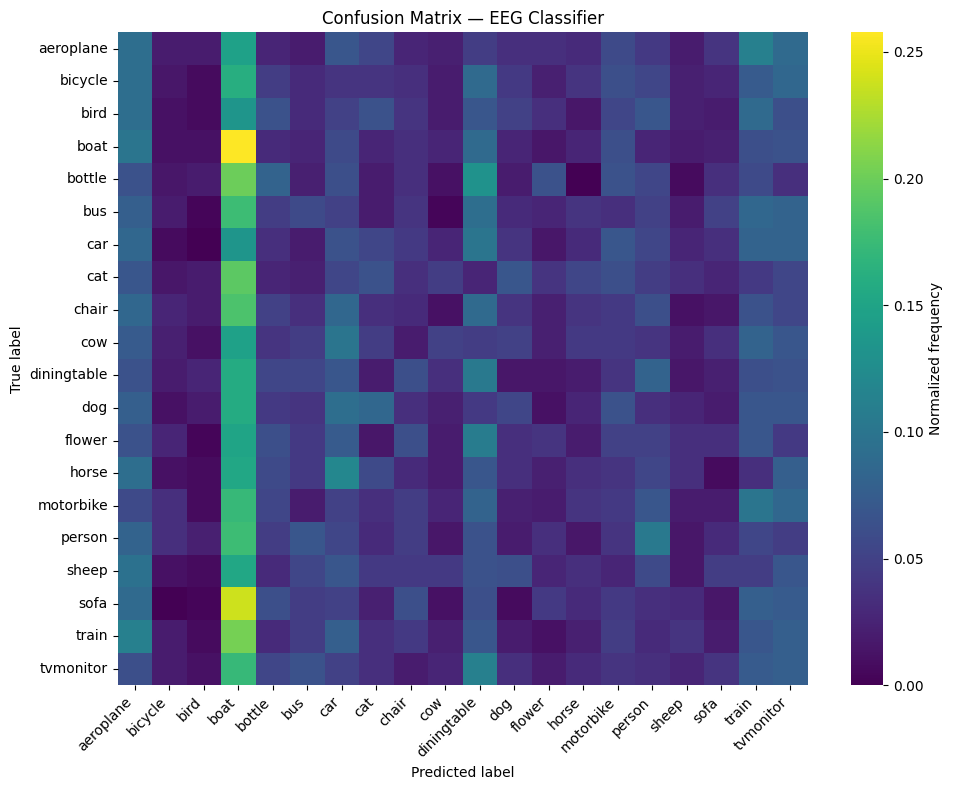

In [29]:
# ===== Cell: confusion matrix visualization =====
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 20-class label mapping (as defined in your dataset)
class_names = [
    'aeroplane','bicycle','bird','boat','bottle',
    'bus','car','cat','chair','cow',
    'diningtable','dog','flower','horse','motorbike',
    'person','sheep','sofa','train','tvmonitor'
]

cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm, 
    annot=False, 
    cmap="viridis", 
    xticklabels=class_names, 
    yticklabels=class_names,
    cbar_kws={'label': 'Normalized frequency'}
)
plt.title("Confusion Matrix — EEG Classifier")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
# ===== Cell: per-class accuracy table =====
import pandas as pd
import numpy as np

cm_sum = cm.sum(axis=1, keepdims=True)
class_acc = np.diag(cm) / cm_sum.squeeze()

acc_df = pd.DataFrame({
    "Category": class_names,
    "Accuracy (%)": (class_acc * 100).round(2)
}).sort_values("Accuracy (%)", ascending=False).reset_index(drop=True)

display(acc_df)

# Optional: export as CSV or LaTeX table
acc_df.to_csv("results_per_class_accuracy.csv", index=False)
with open("results_per_class_accuracy.tex", "w") as f:
    f.write(acc_df.to_latex(index=False, float_format="%.2f"))

,Category,Accuracy (%)
0,boat,25.77
1,diningtable,10.38
2,person,10.38
3,aeroplane,9.23
4,bottle,8.08
5,tvmonitor,7.69
6,train,6.92
7,cat,6.54
8,car,6.54
9,bus,5.77


In [31]:
# ===== Cell: overall test metrics =====
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"✅ Test Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}% | F1-score: {f1*100:.2f}%")

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Value (%)": [acc*100, prec*100, rec*100, f1*100]
})

display(summary_df)

# Save LaTeX-ready version
with open("results_summary.tex", "w") as f:
    f.write(summary_df.to_latex(index=False, float_format="%.2f"))

✅ Test Accuracy: 6.38%
Precision: 6.11% | Recall: 6.38% | F1-score: 5.73%


,Metric,Value (%)
0,Accuracy,6.384615
1,Precision,6.114392
2,Recall,6.384615
3,F1-score,5.727007


In [32]:
# ===== Cell: top confusion pairs =====
import numpy as np
from itertools import product

off_diag = np.copy(cm)
np.fill_diagonal(off_diag, 0)
pairs = sorted(product(range(20), repeat=2), key=lambda x: off_diag[x], reverse=True)
top_pairs = [(class_names[i], class_names[j], off_diag[i, j]) for i, j in pairs[:10]]

pd.DataFrame(top_pairs, columns=["True Label", "Predicted Label", "Count"])

,True Label,Predicted Label,Count
0,sofa,boat,62
1,train,boat,53
2,bottle,boat,52
3,cat,boat,50
4,chair,boat,48
5,bus,boat,46
6,person,boat,46
7,motorbike,boat,45
8,tvmonitor,boat,45
9,bicycle,boat,42
